# Data extraction and visualistation
The Data is extracted from 1000GENOMES:phase3 project

In [1]:
import requests, sys
import matplotlib.pyplot as plt
import numpy as np
import os

from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment
from Bio.Align.Applications import MuscleCommandline
from Bio.Align.Applications import MafftCommandline
from Bio import AlignIO, SeqIO
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord


## Get request to obtain json data

In [4]:
#%store -d ensembl_data # uncomment to send a new GET request
ensembl_data = None
%store -r ensembl_data
if ensembl_data is None:
    print("Sending GET request, this might take a while...")
    server = "https://rest.ensembl.org/transcript_haplotypes/homo_sapiens/"
    # Choose different extension for different gene
    ext = "ENST00000380152?content-type=application/json;sequence=1"

    r = requests.get(server + ext, headers={ "Content-Type" : "application/json"})
    
    
    if not r.ok:
      r.raise_for_status()
      sys.exit()
    print("Data received, decoding...")
    ensembl_data = r.json()
    print("Done.")
%store ensembl_data
#ensembl_data.keys()

Stored 'ensembl_data' (dict)


In [5]:
# ID of the transcript, where we investigate the haplotypes
ensembl_data["transcript_id"]

'ENST00000380152'

### Populations counts
Frequencies of sampled individuals that were sequenced to obtain this haplotypes

<BarContainer object of 31 artists>

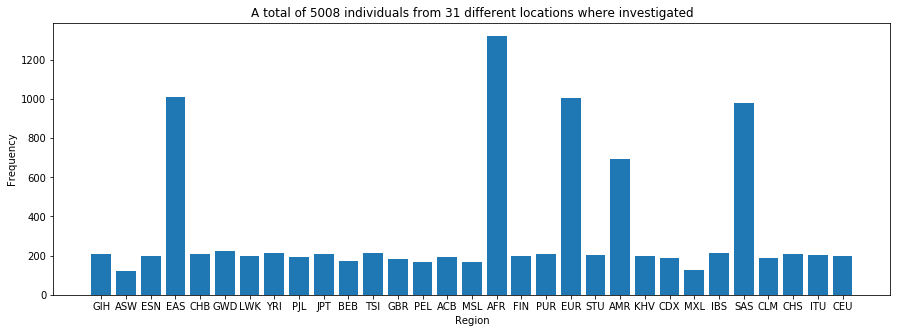

In [6]:
population_counts = ensembl_data["total_population_counts"]
populations = []
counts = []
for key in population_counts:
    if not ('_all' in key or ':ALL' in key):
        name = key.split(sep=":")
        populations.append(name[2])
        counts.append(population_counts[key])

plt.figure(figsize=(15, 5))
plt.title("A total of " + str(population_counts["_all"]) + " individuals from " + str(len(population_counts)-2) + " different locations where investigated")
plt.xlabel("Region")
plt.ylabel("Frequency")
plt.bar(populations, counts, align='center')
    

## Extract sequence data

In [7]:
haplotypes = ensembl_data["cds_haplotypes"]
#haplotypes

In [8]:
def prune_haplotypes(haplotypes):
    ''' Takes a dictionary as returned by e!ensembl and removes all data we don't need.
    Additionally it maps regions to sequences instead of the other way around.
    
    Params:
        haplotypes (dict): Dictionary as returned by e!ensembl
        
    Returns:
        dict: {Region: [{name: name, seq: sequence, count: count}]} dictionary mapping a region to its sequences,
        their names and the amount of times this sequence was found in the respective region.
    '''
    pruned_haplo_dict = {}
    for haplotype in haplotypes:
        name = haplotype['name']
        sequence = haplotype['seq']
        population_counts = haplotype['population_counts']
        for population in population_counts:
            count = population_counts[population]
            if population in pruned_haplo_dict:
                pruned_haplo_dict[population].append({'name' : name, 'seq': sequence, 'count': count})
            else:
                pruned_haplo_dict[population] = [{'name' : name, 'seq': sequence, 'count': count}]
    return pruned_haplo_dict
            
                

In [9]:
pruned_haplos = prune_haplotypes(haplotypes)
#pruned_haplos

In [8]:
seqs = []
i = 0
for haplo in haplotypes:
    i += 1
    seqs.append(SeqRecord(Seq(haplo["seq"], generic_dna), id=str(i)))

In [9]:
def muscle_alignment(seqs):
    """Align 2 sequences with muscle"""
    filename = 'temp.faa'
    SeqIO.write(seqs, filename, "fasta")
    name = os.path.splitext(filename)[0]
    from Bio.Align.Applications import MuscleCommandline
    cline = MuscleCommandline(input=filename, out=name+'.txt')
    stdout, stderr = cline()
    align = AlignIO.read(name+'.txt', 'fasta')
    return align

def mafft_alignment(seqs):
    """Align 2 sequences with muscle"""
    filename = 'temp.faa'
    SeqIO.write(seqs, filename, "fasta")
    name = os.path.splitext(filename)[0]

    cline = MuscleCommandline(input=filename, out=name+'.txt')
    stdout, stderr = cline()
    align = AlignIO.read(name+'.txt', 'fasta')
    return align    

In [13]:
align = mafft_alignment(seqs)

ApplicationError: Non-zero return code 127 from 'muscle -in temp.faa -out temp.txt', message '/bin/sh: 1: muscle: not found'